*A general note on this notebook* - while the analysis for this study of iPTF 16abc is being conducted in an open fashion, we have not obtained permission to share the data of other researchers.

If you are hoping to run this analysis locally, you will need to adjust the absolute paths to the spectral data read in below. These data are from [Dessart et al. 2014](http://cdsads.u-strasbg.fr/abs/2014MNRAS.441..532D), and they are [publically available](https://www-n.oca.eu/supernova/snia/snia_ddc_pddel.html).

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import tables
from astropy.time import Time
import astropy.constants as const
import pandas as pd
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
d14_dir = "/Users/adamamiller/astronomy/SN_Ia_models/Dessart14/SNIa_DDC_DDC10M4_PDDEL_D14b/"

pddel_spec_file = d14_dir + "PDDEL9n_spec_1500_10000_interp5_001.000d.dat"
pddel_w, pddel_f = np.loadtxt(pddel_spec_file, delimiter = "   ", unpack = True)

<IPython.core.display.Javascript object>


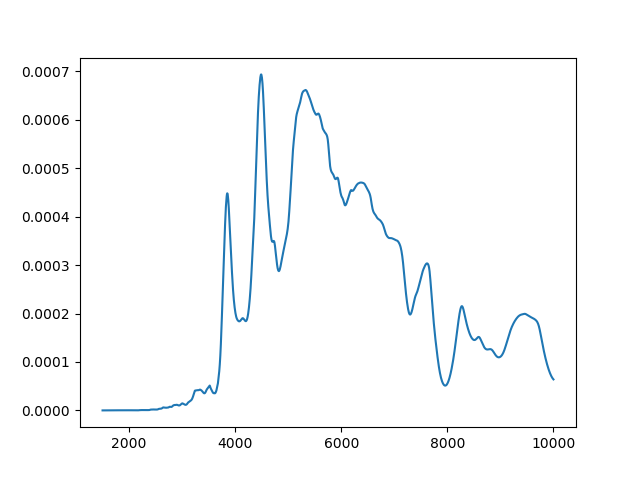

In [4]:
plt.plot(pddel_w, pddel_f)

In [5]:
from scipy import interpolate
from scipy import integrate

class Filter(object):
    
    def __init__(self, name, wavelength, transmission):
        """
        parameters:
            name: filter name
            wavelength: wavelength in Angstrom
            tranmission: in the units of per Angstrom per photon
        """
        self.name = name
        self.wavelength = wavelength
        self.transmission = transmission
        norm = integrate.quad(self._TransmissionInterpolation(),
                              self.wavelength.min(),
                              self.wavelength.max())[0]
        self.transmission /= norm
        self.wavelength_eff = 1 /\
            integrate.quad(interpolate.interp1d(self.wavelength,
                                                self.transmission,
                                                bounds_error=False,
                                                fill_value=0),
                           self.wavelength.min(),
                           self.wavelength.max())[0]
        
    def _TransmissionInterpolation(self):
        return interpolate.interp1d(self.wavelength, 
                                    self.transmission * self.wavelength, 
                                    bounds_error=False, 
                                    fill_value=0)
    
    def TransmissionCurve(self, wv):
        return self._TransmissionInterpolation()(wv)

In [6]:
import extinction_cal

class Spectrum(object):
    
    def __init__(self, wavelength, flux):
        self.wavelength = wavelength
        self.flux = flux
        
    def extinction(self, EBV, RV=3.1):
        A = extinction_cal.calALambda(self.wavelength, RV, EBV)
        self.flux *= 10**(-A/2.5)
        
    def redshift(self, z):
        self.wavelength *= (1 + z)
        self.flux /= (1 + z)
        
    def SyntheticPhotometry(self, filter_curve):
        func = lambda wv: interpolate.interp1d(self.wavelength,
                                               self.flux * filter_curve.TransmissionCurve(self.wavelength),
                                               bounds_error=False,
                                               fill_value=0)(wv)
        return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]

In [40]:
# g-band filter
data = np.genfromtxt('../data/filters/P48/P48_g.dat', 
                     names=["wavelength", "transmission"])
gP48_curve = Filter("P48_g", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/P48/P48_R.dat', 
                     names=["wavelength", "transmission"])
RP48_curve = Filter("P48_R", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/LCO/jnsn-bu-183_eff.txt', 
                     names=["wavelength", "transmission"])
B_curve = Filter("B", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/LCO/jnsn-vx-183_eff.txt', 
                     names=["wavelength", "transmission"])
V_curve = Filter("V", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/LCO/sdss-gp-183_eff.txt', 
                     names=["wavelength", "transmission"])
g_curve = Filter("g", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/LCO/sdss-rp-183_eff.txt', 
                     names=["wavelength", "transmission"])
r_curve = Filter("r", data["wavelength"], data["transmission"])

data = np.genfromtxt('../data/filters/LCO/sdss-ip-183_eff.txt', 
                     names=["wavelength", "transmission"])
i_curve = Filter("i", data["wavelength"], data["transmission"])

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [15]:
spec_obj = Spectrum(pddel_w, pddel_f)

In [17]:
obs_flux = spec_obj.SyntheticPhotometry(filter_curve)  # F_lambda
obs_flux *= filter_curve.wavelength_eff * (filter_curve.wavelength_eff * 1e-8 / const.c.cgs.value) * 1e23  # F_nu in Jy

-2.5*np.log10(obs_flux/3631)

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


-12.570485617404803

In [27]:
# make a light curve

from glob import glob

model_spectra = glob(d14_dir + "PDDEL9n*.dat")
model_t = np.empty(len(model_spectra))
model_mag = np.empty(len(model_spectra))
for specnum, specfile in enumerate(model_spectra):
    t = specfile.split("_")[-1].split('d')[0]
    model_t[specnum] = float(t)
    spec_wave, spec_flux = np.loadtxt(specfile, 
                                      delimiter = "   ", 
                                      unpack = True)
    spec_obj = Spectrum(spec_wave, spec_flux)
    obs_flux = spec_obj.SyntheticPhotometry(filter_curve)  # F_lambda
    lambda_eff = filter_curve.wavelength_eff
    obs_flux *= lambda_eff**2/const.c.to('Angstrom/s').value * 1e23  # F_nu in Jy

    model_mag[specnum] = -2.5*np.log10(obs_flux/3631)

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [43]:
models = glob(d14_dir + "*d")
for model in models:
    model_spectra = glob("{:s}*.dat".format(model.split("_SN_HYDRO")[0]))
    model_t = np.empty(len(model_spectra))
    model_gP48 = np.empty(len(model_spectra))
    model_RP48 = np.empty(len(model_spectra))
    model_B = np.empty(len(model_spectra))
    model_V = np.empty(len(model_spectra))
    model_g = np.empty(len(model_spectra))
    model_r = np.empty(len(model_spectra))
    model_i = np.empty(len(model_spectra))

    for specnum, specfile in enumerate(model_spectra):
        t = specfile.split("_")[-1].split('d')[0]
        model_t[specnum] = float(t)
        spec_wave, spec_flux = np.loadtxt(specfile, 
                                          delimiter = "   ", 
                                          unpack = True)
        spec_obj = Spectrum(spec_wave, spec_flux)
        for filt in ["gP48", "RP48", "B", "V", "g", "r", "i"]:
            exec("obs_flux = spec_obj.SyntheticPhotometry({:s}_curve)".format(filt))  # F_lambda
            exec("lambda_eff = {:s}_curve.wavelength_eff".format(filt))
            obs_flux *= lambda_eff**2/const.c.to('Angstrom/s').value * 1e23  # F_nu in Jy

            exec("model_{:s}[specnum] = -2.5*np.log10(obs_flux/3631)".format(filt))
    lc_df = pd.DataFrame(model_t, columns = ["time"])
    for filt in ["gP48", "RP48", "B", "V", "g", "r", "i"]:
        exec("lc_df[filt] = model_{:s}".format(filt))
    lc_df.to_hdf(model.split("/")[-1].split("_SN_")[0] + "_lc.h5", "lc")

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [42]:
pd.__version__

'0.19.2'